In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
!pip install tensorflow


In [2]:
temperature = pd.read_csv('temperature.csv')
humidity = pd.read_csv('humidity.csv')
pressure = pd.read_csv('pressure.csv')
wind_speed = pd.read_csv('wind_speed.csv')
wind_direction = pd.read_csv('wind_direction.csv')
weather_desc = pd.read_csv('weather_description.csv')  # Şimdilik kullanılmıyor

In [3]:
for df in [temperature, humidity, pressure, wind_speed, wind_direction]:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df.set_index('datetime', inplace=True)

In [4]:
cities = list(set(temperature.columns) &
              set(humidity.columns) &
              set(pressure.columns) &
              set(wind_speed.columns) &
              set(wind_direction.columns))

print("Mevcut şehirler:", cities)
selected_city = input("Tahmin yapılacak şehir adını girin: ")

if selected_city not in cities:
    raise ValueError(f"'{selected_city}' adlı şehir veri setlerinde yok.")

Mevcut şehirler: ['Pittsburgh', 'Minneapolis', 'Houston', 'Charlotte', 'Vancouver', 'Dallas', 'Tel Aviv District', 'Haifa', 'Detroit', 'Phoenix', 'San Antonio', 'Kansas City', 'Atlanta', 'San Francisco', 'Nashville', 'Denver', 'Boston', 'Los Angeles', 'Indianapolis', 'Las Vegas', 'Albuquerque', 'Miami', 'San Diego', 'Eilat', 'Nahariyya', 'Seattle', 'New York', 'Toronto', 'Saint Louis', 'Jerusalem', 'Montreal', 'Portland', 'Chicago', 'Philadelphia', 'Jacksonville', 'Beersheba']
Tahmin yapılacak şehir adını girin: Pittsburgh


In [5]:
df = pd.concat([
    temperature[selected_city],
    humidity[selected_city],
    pressure[selected_city],
    wind_speed[selected_city],
    wind_direction[selected_city]
], axis=1)

df.columns = ['temperature', 'humidity', 'pressure', 'wind_speed', 'wind_direction']
df.dropna(inplace=True)

In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


In [7]:
def create_sequences(data, input_len=72, output_len=72):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)

In [8]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    Dense(X.shape[2])  # temp, hum, pressure, wind speed, wind direction
])

model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
model.fit(X, y, epochs=1, batch_size=64, validation_split=0.2)

557/557 ━━━━━━━━━━━━━━━━━━━━ 161s 277ms/step - loss: 0.0448 - val_loss: 0.0242


In [10]:
last_seq = scaled_data[-72:]
last_seq = np.expand_dims(last_seq, axis=0)
pred_scaled = model.predict(last_seq)[0]  # (72, 5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


In [11]:
pred = scaler.inverse_transform(pred_scaled)
temperature_pred = pred[:, 0] - 273.15
humidity_pred = pred[:, 1]
pressure_pred = pred[:, 2]
wind_speed_pred = pred[:, 3]
wind_direction_pred = pred[:, 4]

<ipython-input-12-5e268d5e6798>:41: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-5e268d5e6798>:41: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-5e268d5e6798>:41: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-5e268d5e6798>:41: UserWarning: Glyph 127786 (\N{CLOUD WITH TORNADO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-12-5e268d5e6798>:41: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128167 (\N{DROPLET}) missing from fon

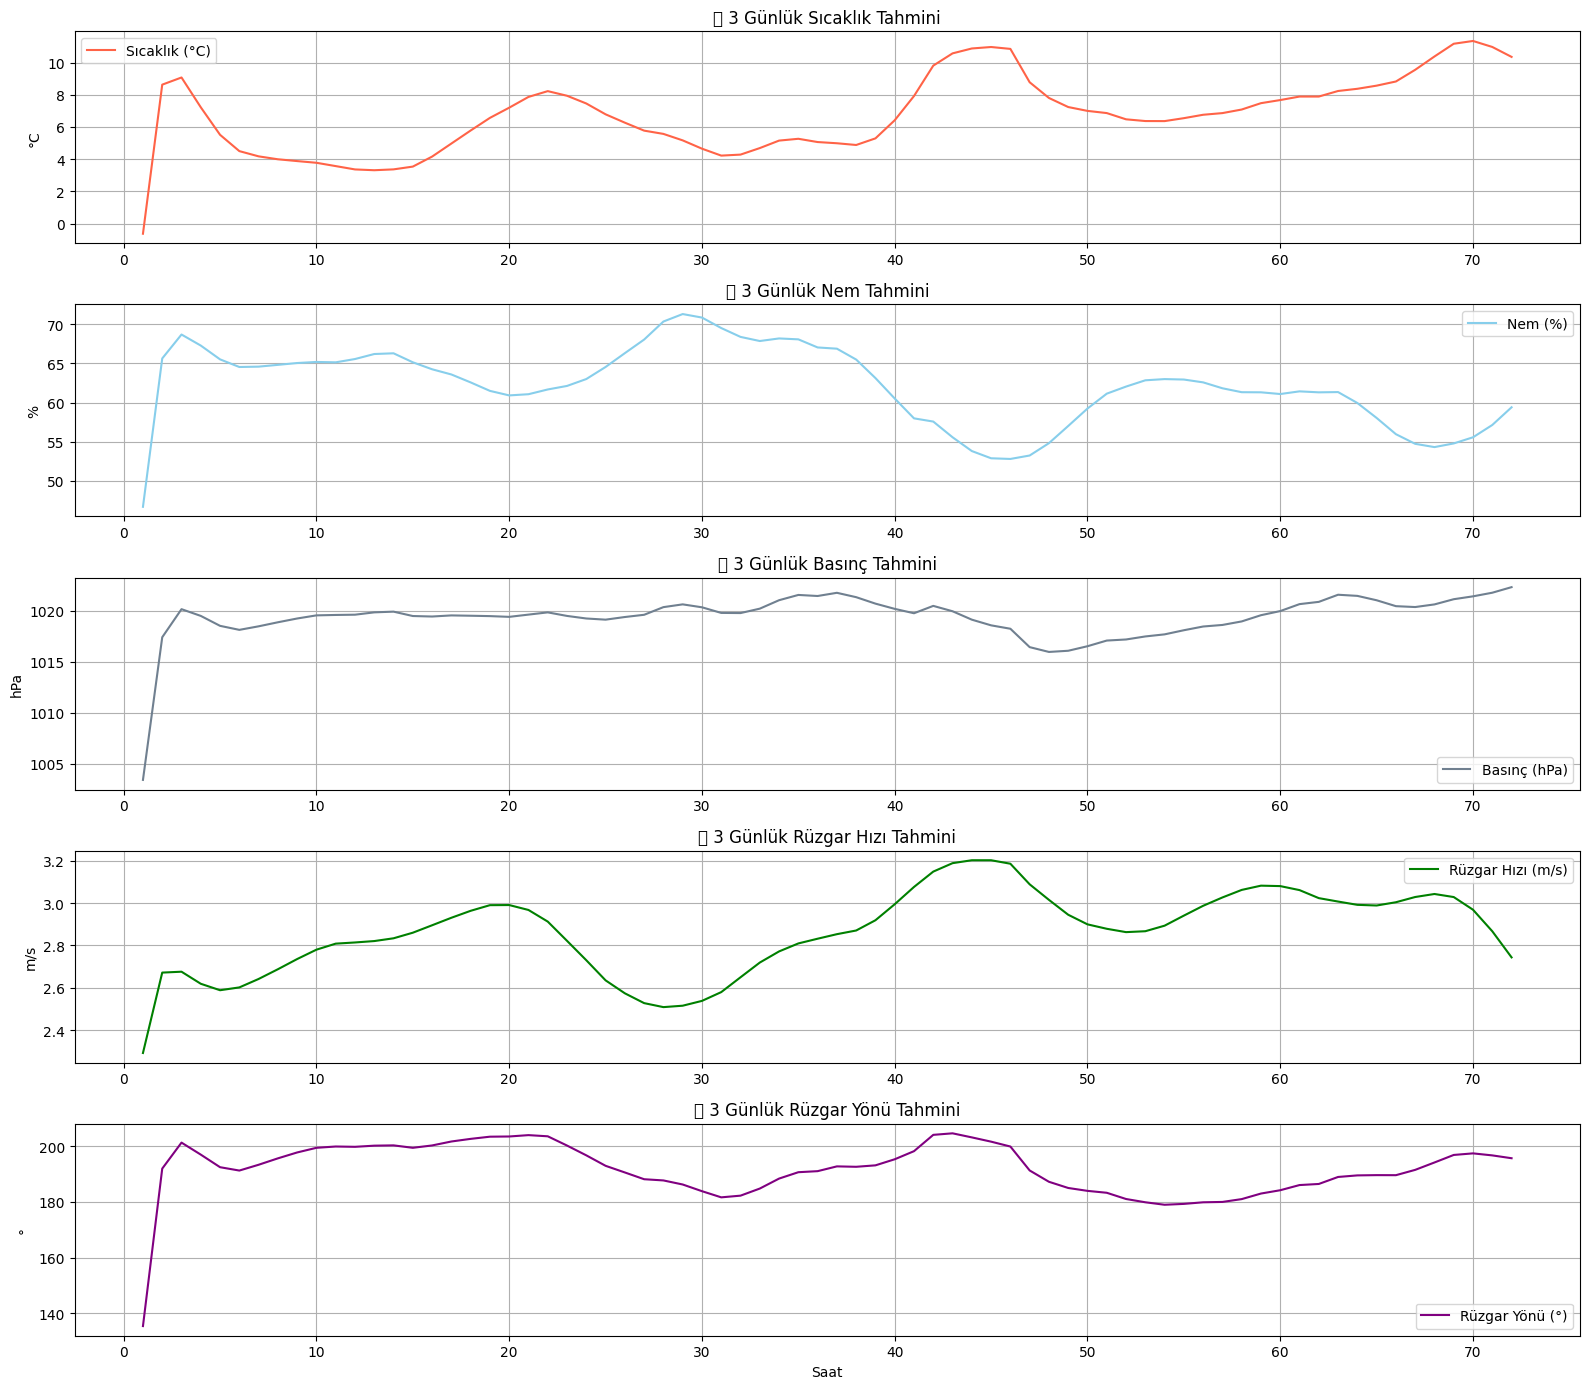

In [12]:
hours = np.arange(1, 73)

plt.figure(figsize=(16, 14))

plt.subplot(5, 1, 1)
plt.plot(hours, temperature_pred, color='tomato', label='Sıcaklık (°C)')
plt.ylabel("°C")
plt.title("🌡️ 3 Günlük Sıcaklık Tahmini")
plt.grid(True)
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(hours, humidity_pred, color='skyblue', label='Nem (%)')
plt.ylabel("%")
plt.title("💧 3 Günlük Nem Tahmini")
plt.grid(True)
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(hours, pressure_pred, color='slategray', label='Basınç (hPa)')
plt.ylabel("hPa")
plt.title("🌬️ 3 Günlük Basınç Tahmini")
plt.grid(True)
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(hours, wind_speed_pred, color='green', label='Rüzgar Hızı (m/s)')
plt.ylabel("m/s")
plt.title("🌪️ 3 Günlük Rüzgar Hızı Tahmini")
plt.grid(True)
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(hours, wind_direction_pred, color='purple', label='Rüzgar Yönü (°)')
plt.ylabel("°")
plt.xlabel("Saat")
plt.title("🧭 3 Günlük Rüzgar Yönü Tahmini")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()